Mean Absolute Error (log scale): 0.064426196059955
RMSE (log scale): 0.10234841790627935
R² Score: 0.8505887917723056


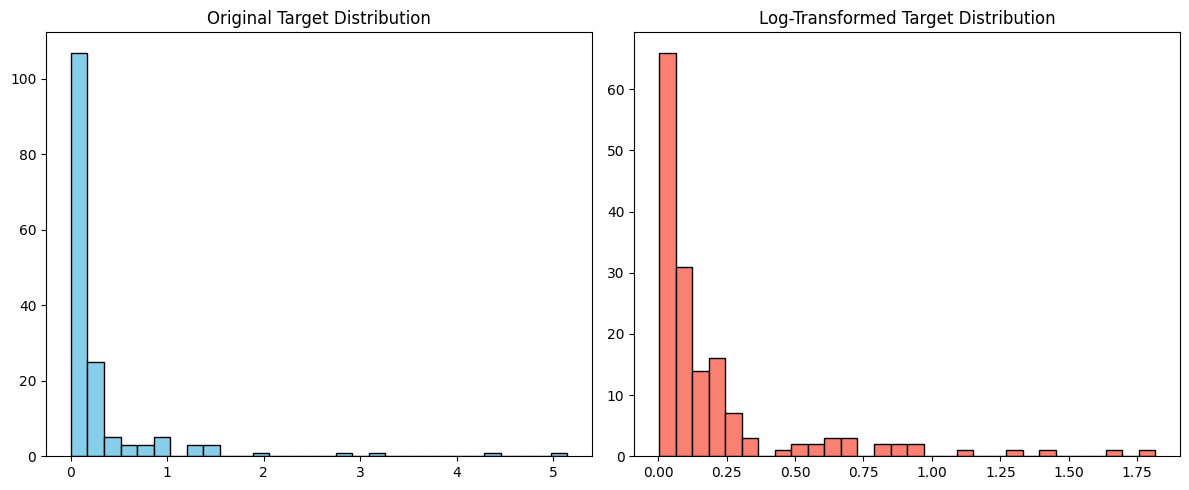

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import TheilSenRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load and preprocess data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')

# Drop irrelevant columns
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

# Define numerical and categorical columns
num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)', 'Heat Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material Designation',
    'Surface Treatment', 'Raw Material'
]

# Fill missing values
df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

# Define target variable
TARGET = 'Total cost with amortization (€/part)'
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Log-transform the skewed target variable
y_log = np.log1p(y)  # log(1 + y) to handle zero values safely

# Preprocessing pipeline with dense output
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# Theil-Sen regression model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', TheilSenRegressor(random_state=42))
])

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluation
mae_scores = cross_val_score(model, X, y_log, cv=kf, scoring='neg_mean_absolute_error')
rmse_scores = cross_val_score(model, X, y_log, cv=kf, scoring='neg_root_mean_squared_error')
r2_scores = cross_val_score(model, X, y_log, cv=kf, scoring='r2')

# Output results
print("Mean Absolute Error (log scale):", -mae_scores.mean())
print("RMSE (log scale):", -rmse_scores.mean())
print("R² Score:", r2_scores.mean())

# Optional: Visualize target distribution before and after log-transform
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(y, bins=30, color='skyblue', edgecolor='black')
plt.title("Original Target Distribution")

plt.subplot(1, 2, 2)
plt.hist(y_log, bins=30, color='salmon', edgecolor='black')
plt.title("Log-Transformed Target Distribution")

plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Drop irrelevant columns
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
])

# Remove rows with missing values in relevant columns
df = df[['Final Raw Material cost (€/Part)', 'Final cost with amortization']].dropna()

# Features and target
X = df[['Final Raw Material cost (€/Part)']].values
y = df['Final cost with amortization'].values

# Initialize results
results = []

# Loop over training sizes from 90% to 100% (step = 5%)
for train_pct in range(90, 101, 5):
    split_idx = int(len(X) * (train_pct / 100))
    
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    if len(X_test) == 0:
        continue  # Skip if there's no test set

    # Fit linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    coef = model.coef_[0]
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    # Append to results
    results.append({
        'Train %': train_pct,
        'Test %': 100 - train_pct,
        'Linear Coefficient': coef,
        'MAE': mae,
        'MAPE (%)': mape
    })

# Convert to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)


KeyError: "['Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)', 'Gross Weight (g)', 'Other assembled RM/Rivet/part'] not found in axis"